In [1]:
from itertools import combinations
from collections import Counter

from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import torch.nn as nn

In [2]:
FILE = "./../data/août 2023/2025-03-31T20:50:08.359657.pkl"

In [3]:
df = pd.read_pickle(FILE)
df = pd.DataFrame(df[::-1])
df.head()

,draw_date,numbers,bonus,type
0,2023-08-01,"[62, 87, 30, 3, 52]",None,FORTUNE_18H
1,2023-08-01,"[30, 31, 13, 20, 48]",None,FORTUNE_14H
2,2023-08-01,"[15, 29, 80, 77, 17]",None,FORTUNE_11H
3,2023-08-02,"[90, 68, 4, 2, 75]",None,STAR_18H
4,2023-08-02,"[69, 65, 33, 44, 2]",None,STAR_14H


In [4]:
def process_dataframe(df):
    # Extract the hour from the 'type' column
    df['hour'] = df['type'].str.extract(r'_(\d{2})H').astype(int)

    # Combine 'draw_date' and 'hour' to create a datetime column
    df['datetime'] = pd.to_datetime(df['draw_date']) + pd.to_timedelta(df['hour'], unit='h')

    # Drop the temporary 'hour' column if no longer needed
    df.drop(columns=['hour'], inplace=True)

    # Separate the 'type' column into two new columns: 'category' and 'hour_label'
    df[['category', 'hour_label']] = df['type'].str.split('_', expand=True).iloc[:, [0, -1]]

    # Sort the dataframe by 'datetime' within each 'category'
    df = df.sort_values(by=['datetime', 'category']).reset_index(drop=True)
    # Adjust 'numbers' and set 'bonus' if the length of 'numbers' is 6
    df['bonus'] = df['numbers'].apply(lambda x: x.pop() if len(x) == 6 else None)
    numbers_df = pd.DataFrame(df['numbers'].tolist(), columns=['num1', 'num2', 'num3', 'num4', 'num5'], dtype=np.int32)
    df = pd.concat([df, numbers_df], axis=1)
    df = df[['datetime', 'category', 'num1', 'num2', 'num3', 'num4', 'num5', 'bonus']]
    return df
# Example usage:
df = process_dataframe(df)
df.head(10)

,datetime,category,num1,num2,num3,num4,num5,bonus
0,2023-08-01 11:00:00,FORTUNE,15,29,80,77,17,NaN
1,2023-08-01 14:00:00,FORTUNE,30,31,13,20,48,NaN
2,2023-08-01 18:00:00,FORTUNE,62,87,30,3,52,NaN
3,2023-08-02 11:00:00,STAR,65,74,17,42,34,NaN
4,2023-08-02 14:00:00,STAR,69,65,33,44,2,NaN
5,2023-08-02 18:00:00,STAR,90,68,4,2,75,NaN
6,2023-08-03 11:00:00,FORTUNE,29,77,53,71,23,NaN
7,2023-08-03 14:00:00,FORTUNE,55,37,28,44,8,NaN
8,2023-08-03 18:00:00,FORTUNE,74,50,19,13,83,NaN
9,2023-08-04 11:00:00,FORTUNE,23,88,79,60,19,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93 entries, 0 to 92
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   datetime  93 non-null     datetime64[ns]
 1   category  93 non-null     object        
 2   num1      93 non-null     int32         
 3   num2      93 non-null     int32         
 4   num3      93 non-null     int32         
 5   num4      93 non-null     int32         
 6   num5      93 non-null     int32         
 7   bonus     12 non-null     float64       
dtypes: datetime64[ns](1), float64(1), int32(5), object(1)
memory usage: 4.1+ KB


Basic Statistics:
                  datetime       num1       num2      num3       num4  \
count                   93  93.000000  93.000000  93.00000  93.000000   
mean   2023-08-16 14:20:00  47.763441  47.387097  40.27957  43.924731   
min    2023-08-01 11:00:00   2.000000   1.000000   2.00000   1.000000   
25%    2023-08-08 18:00:00  24.000000  22.000000  17.00000  24.000000   
50%    2023-08-16 14:00:00  53.000000  50.000000  30.00000  42.000000   
75%    2023-08-24 11:00:00  69.000000  73.000000  65.00000  64.000000   
max    2023-08-31 18:00:00  90.000000  89.000000  90.00000  90.000000   
std                    NaN  25.744733  27.174169  28.11520  25.023570   

            num5      bonus  
count  93.000000  12.000000  
mean   42.215054  45.083333  
min     2.000000   2.000000  
25%    20.000000  32.250000  
50%    44.000000  48.500000  
75%    63.000000  57.500000  
max    90.000000  81.000000  
std    25.555077  23.070872  

Missing Values:
datetime     0
category     0
num1   

<Figure size 1200x600 with 0 Axes>

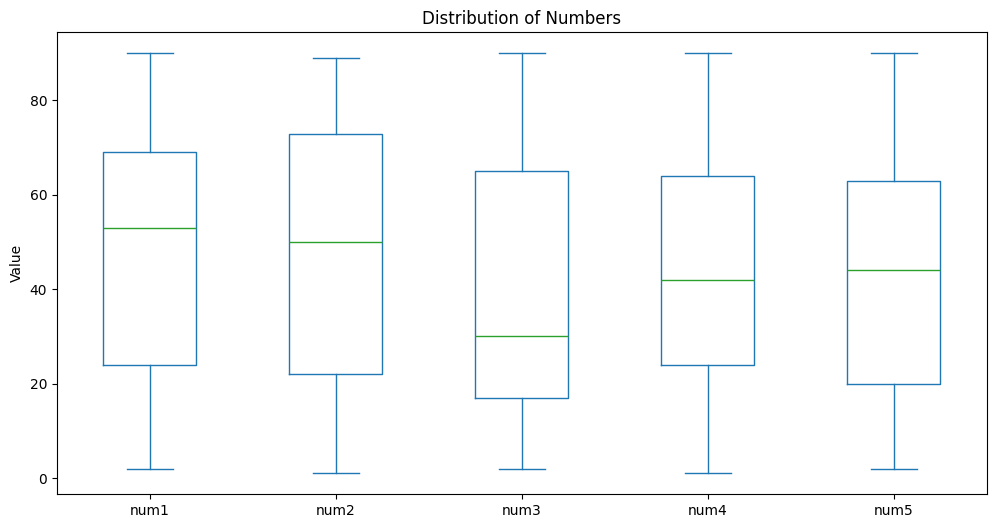

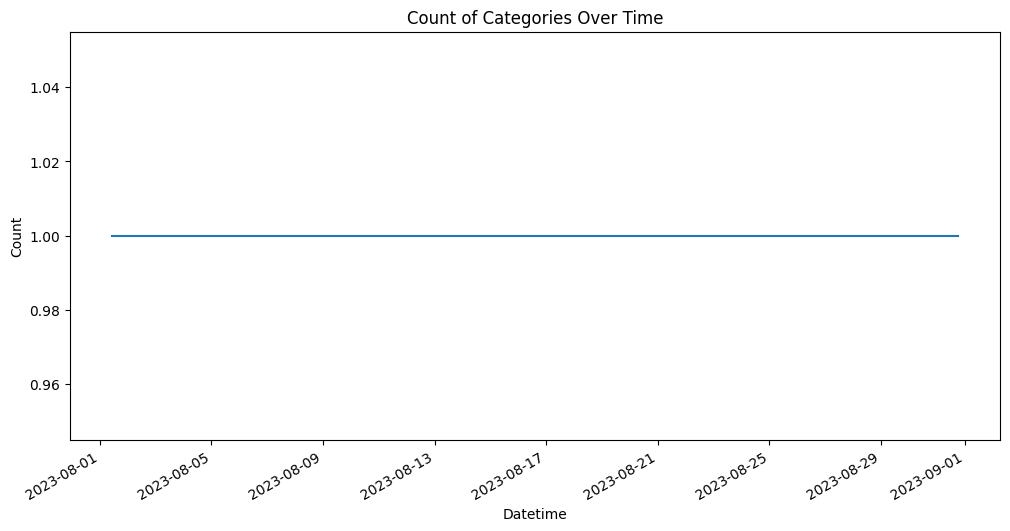

In [6]:
# Display basic statistics
print("Basic Statistics:")
print(df.describe())

# Check for missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Distribution of categories
print("\nCategory Distribution:")
print(df['category'].value_counts())

# Plot the distribution of numbers
plt.figure(figsize=(12, 6))
df[['num1', 'num2', 'num3', 'num4', 'num5']].plot(kind='box', figsize=(12, 6))
plt.title("Distribution of Numbers")
plt.ylabel("Value")
plt.show()

# Plot the count of categories over time
plt.figure(figsize=(12, 6))
df.groupby('datetime')['category'].count().plot()
plt.title("Count of Categories Over Time")
plt.xlabel("Datetime")
plt.ylabel("Count")
plt.show()

In [7]:
import os
from datetime import datetime

def get_last_file(base_path):
    last_file = None
    last_timestamp = None

    for root, dirs, files in os.walk(base_path):
        for file in files:
            try:
                # Extract the timestamp from the filename
                timestamp_str = file.split('.')[0]
                timestamp = datetime.fromisoformat(timestamp_str)

                # Update the last file if this one is more recent
                if last_timestamp is None or timestamp > last_timestamp:
                    last_file = os.path.join(root, file)
                    last_timestamp = timestamp
            except ValueError:
                # Skip files that don't have a valid ISO timestamp
                continue

    return last_file

# Example usage
base_path = './../data/mars 2025'
last_file = get_last_file(base_path)
print("Last file:", last_file)

Last file: ./../data/mars 2025/2025-04-03T09:15:11.387104.pkl


In [8]:
MONTH = [
    "janvier",
    "février",
    "mars",
    "avril",
    "mai",
    "juin",
    "juillet",
    "août",
    "septembre",
    "octobre",
    "novembre",
    "décembre",
]
YEARS = ["2023", "2024", "2025"]

for year in YEARS:
    for month in MONTH:
        path = f"./../data/{month} {year}"
        last_file = get_last_file(path)
        if last_file:
            # print("Last file:", last_file)
            df = pd.read_pickle(last_file)
            df = pd.DataFrame(df[::-1])
            # print(df.head())
            df = process_dataframe(df)
            if 'final_df' in locals():
                final_df = pd.concat([final_df, df], ignore_index=True)
            else:
                final_df = df
# Save the final DataFrame to a pickle file
final_df.to_pickle(f"./../data/outputs/{datetime.now()}.pkl")
final_df.shape

/tmp/ipykernel_56174/1612632499.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([final_df, df], ignore_index=True)
/tmp/ipykernel_56174/1612632499.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([final_df, df], ignore_index=True)
/tmp/ipykernel_56174/1612632499.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when de

(2380, 8)

In [9]:
final_df.head(10)

,datetime,category,num1,num2,num3,num4,num5,bonus
0,2023-05-13 14:00:00,STAR,47,64,39,66,26,NaN
1,2023-05-13 18:00:00,STAR,12,54,62,38,53,NaN
2,2023-05-14 14:00:00,STAR,38,21,40,82,52,NaN
3,2023-05-14 18:00:00,STAR,6,55,54,25,80,NaN
4,2023-05-15 14:00:00,FORTUNE,53,51,19,36,49,43.0
5,2023-05-15 18:00:00,FORTUNE,50,61,20,54,4,58.0
6,2023-05-16 14:00:00,FORTUNE,10,67,9,37,18,NaN
7,2023-05-16 18:00:00,FORTUNE,71,84,5,56,70,NaN
8,2023-05-17 14:00:00,STAR,87,46,78,29,38,NaN
9,2023-05-17 18:00:00,STAR,79,57,24,26,65,NaN


In [10]:
final_df.loc[38]

datetime    2023-06-01 14:00:00
category                FORTUNE
num1                         68
num2                         82
num3                         15
num4                         14
num5                         12
bonus                       NaN
Name: 38, dtype: object

In [11]:
final_df.loc[37]

datetime    2023-05-31 18:00:00
category                   STAR
num1                         74
num2                         25
num3                         77
num4                         13
num5                         78
bonus                       NaN
Name: 37, dtype: object

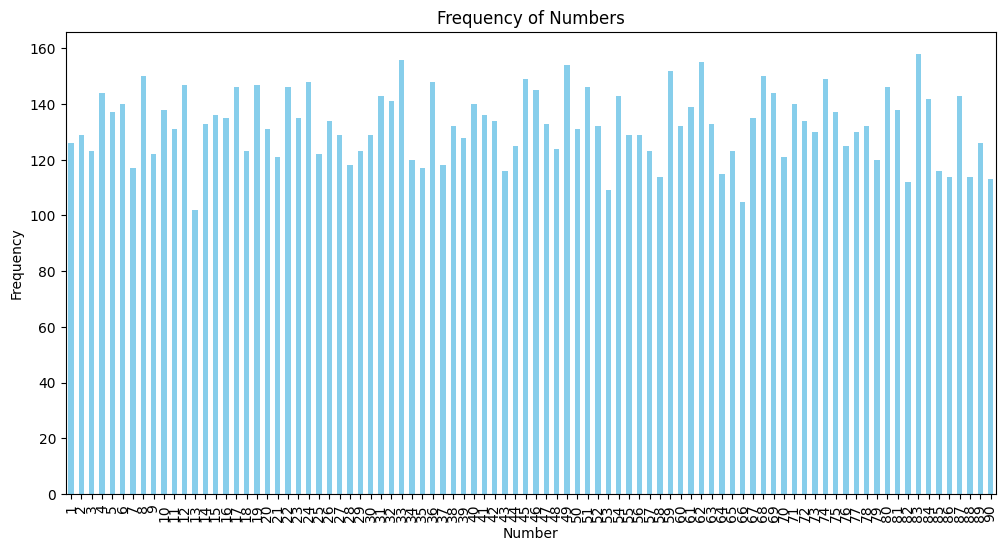

Most Common Pairs: [((np.int32(72), np.int32(83)), 17), ((np.int32(4), np.int32(6)), 16), ((np.int32(68), np.int32(80)), 16), ((np.int32(19), np.int32(49)), 15), ((np.int32(16), np.int32(61)), 15), ((np.int32(54), np.int32(71)), 15), ((np.int32(6), np.int32(81)), 15), ((np.int32(54), np.int32(59)), 15), ((np.int32(54), np.int32(62)), 14), ((np.int32(22), np.int32(40)), 14)]


<Figure size 1200x600 with 0 Axes>

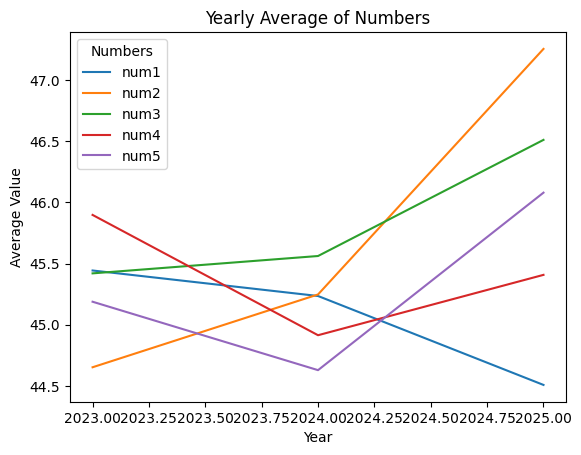

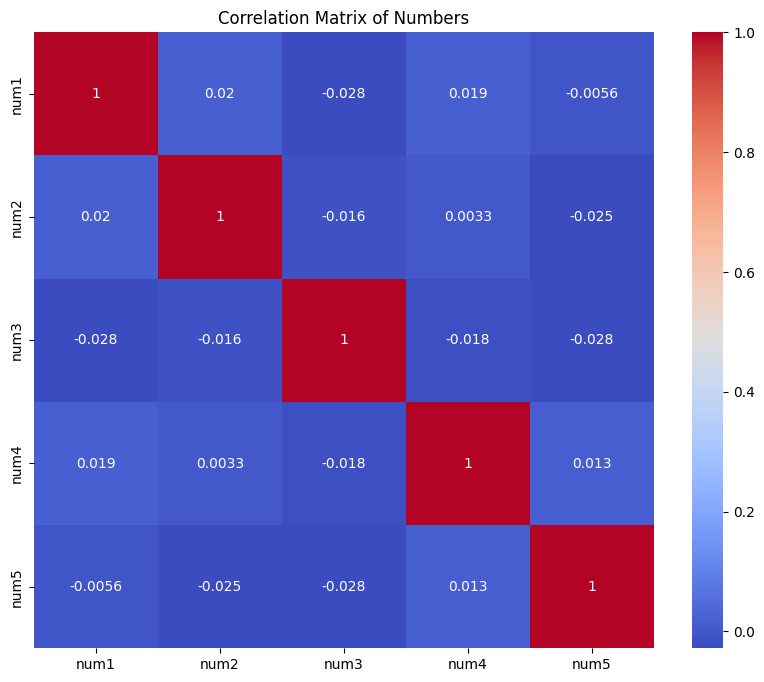

In [12]:
# Analyze number frequencies
number_columns = ['num1', 'num2', 'num3', 'num4', 'num5']
all_numbers = final_df[number_columns].values.flatten()
number_counts = pd.Series(all_numbers).value_counts().sort_index()

plt.figure(figsize=(12, 6))
number_counts.plot(kind='bar', color='skyblue')
plt.title("Frequency of Numbers")
plt.xlabel("Number")
plt.ylabel("Frequency")
plt.show()

# Analyze pairwise combinations

pairs = []
for row in final_df[number_columns].values:
    pairs.extend(combinations(sorted(row), 2))

pair_counts = Counter(pairs).most_common(10)
print("Most Common Pairs:", pair_counts)

# Analyze temporal trends
plt.figure(figsize=(12, 6))
final_df.groupby(final_df['datetime'].dt.year)[number_columns].mean().plot()
plt.title("Yearly Average of Numbers")
plt.xlabel("Year")
plt.ylabel("Average Value")
plt.legend(title="Numbers")
plt.show()

# Feature engineering: Lag features
for col in number_columns:
    final_df[f'{col}_lag1'] = final_df[col].shift(1)

# Feature engineering: Rolling statistics
for col in number_columns:
    final_df[f'{col}_rolling_mean'] = final_df[col].rolling(window=5).mean()

# Correlation analysis
plt.figure(figsize=(10, 8))
sns.heatmap(final_df[number_columns].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Numbers")
plt.show()

In [13]:
FILE = get_last_file("./../data/outputs/")
if FILE:
    df = pd.read_pickle(FILE)
else:
    # If no file is found, use the last processed DataFrame
    df = final_df

print(df.head(10))
print(df.tail(10))
print(df.shape)
print(df.info())

             datetime category  num1  num2  num3  num4  num5  bonus
0 2023-05-13 14:00:00     STAR    47    64    39    66    26    NaN
1 2023-05-13 18:00:00     STAR    12    54    62    38    53    NaN
2 2023-05-14 14:00:00     STAR    38    21    40    82    52    NaN
3 2023-05-14 18:00:00     STAR     6    55    54    25    80    NaN
4 2023-05-15 14:00:00  FORTUNE    53    51    19    36    49   43.0
5 2023-05-15 18:00:00  FORTUNE    50    61    20    54     4   58.0
6 2023-05-16 14:00:00  FORTUNE    10    67     9    37    18    NaN
7 2023-05-16 18:00:00  FORTUNE    71    84     5    56    70    NaN
8 2023-05-17 14:00:00     STAR    87    46    78    29    38    NaN
9 2023-05-17 18:00:00     STAR    79    57    24    26    65    NaN
                datetime category  num1  num2  num3  num4  num5  bonus
2370 2025-04-01 11:00:00  FORTUNE    29    17    55    26    20    NaN
2371 2025-04-01 14:00:00  FORTUNE    71    30    45    29    72    NaN
2372 2025-04-01 18:00:00  FORTUNE    72